<a href="https://colab.research.google.com/github/AlirezaFB01/Machine-learning/blob/main/Ensemble%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [22]:
class DecisionStump:
    """
    A decision stump classifier for multi-class classification problems (depth = 1).
    """

    def __init__(self):
        self.feature = None
        self.threshold = None
        self.value_left = None
        self.value_right = None

    def fit(self, X, y):
        """
        Fits a decision stump to the dataset (X, y).
        """
        best_gain = -1
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                left_y, right_y = y[left_mask], y[right_mask]
                if len(left_y) and len(right_y):
                    left_weight = len(left_y) / len(y)
                    right_weight = 1 - left_weight
                    gain = self._entropy(y) - (left_weight * self._entropy(left_y) + right_weight * self._entropy(right_y))
                    if gain > best_gain:
                        best_gain = gain
                        self.feature = feature_index
                        self.threshold = threshold
                        self.value_left = np.bincount(left_y).argmax()
                        self.value_right = np.bincount(right_y).argmax()

    def predict(self, X):
        """
        Predicts class labels for samples in X.
        """
        return np.where(X[:, self.feature] <= self.threshold, self.value_left, self.value_right)

    def _entropy(self, y):
        """
        Computes entropy for a set of labels.
        """
        proportions = np.bincount(y) / len(y)
        return -np.sum([p * np.log2(p) for p in proportions if p > 0])

In [23]:
from sklearn.datasets import load_iris

iris = load_iris()

X, y = iris.data, iris.target

print(f"Iris features: {iris.feature_names}")
print(f"Iris target: {iris.target_names}")

Iris features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Iris target: ['setosa' 'versicolor' 'virginica']


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y.flatten(), test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_train: (120, 4), y_train: (120,)
Shape of X_test: (30, 4), y_test: (30,)


Now we can train our custom `DecisionTree()` model and evaluate its performance using both the `accuracy_score` and the `f1_score`.

In [25]:
from sklearn.metrics import accuracy_score, f1_score

stump = DecisionStump()
stump.fit(X_train, y_train)

stump_predictions = stump.predict(X_test)

print(f"Decision Stump Accuracy: {accuracy_score(y_test, stump_predictions):.3f}")
print(f"Decision Stump F1-Score: {f1_score(y_test, stump_predictions, average='weighted'):.3f}")

Decision Stump Accuracy: 0.633
Decision Stump F1-Score: 0.520


Sklearn DT Accuracy: 0.967
Sklearn DT F1-Score: 0.966


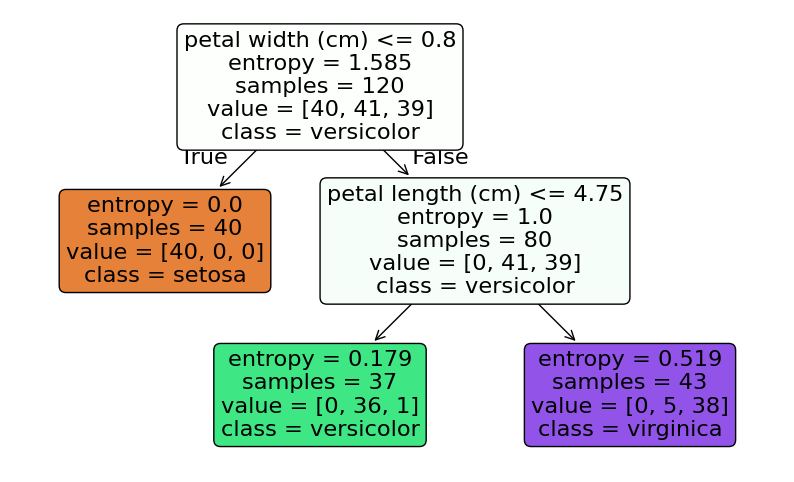

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_sklearn = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt_sklearn.fit(X_train, y_train)

dt_skl_predictions = dt_sklearn.predict(X_test)

print(f"Sklearn DT Accuracy: {accuracy_score(y_test, dt_skl_predictions):.3f}")
print(f"Sklearn DT F1-Score: {f1_score(y_test, dt_skl_predictions, average='weighted'):.3f}")

plt.figure(figsize=(10,6))
plt.title("Decision Tree Visualization - Sklearn")
plot_tree(dt_sklearn, feature_names=list(iris.feature_names), class_names=list(iris.target_names), filled=True, rounded=True)
plt.show()

In the plot above, you can see the decision rules that have been made for splitting the dataset.

In [27]:
from sklearn.utils import resample

class RandomForest:
    """
    A random forest classifier for multi-class classification problems (using decision stumps with depth 1).
    """

    def __init__(self, n_trees=7):
        self.n_trees = n_trees
        self.trees = []

    def fit(self, X, y):
        """
        Fits a random forest to the dataset (X, y).
        """
        self.trees = []
        for _ in range(self.n_trees):
            stump = DecisionStump()
            X_sample, y_sample = self._bootstrap_samples(X, y)
            stump.fit(X_sample, y_sample)
            self.trees.append(stump)

    def predict(self, X):
        """
        Predicts class labels for samples in X.
        """
        stump_predictions = np.array([stump.predict(X) for stump in self.trees])
        return self._majority_vote(stump_predictions)

    def _bootstrap_samples(self, X, y):
        """
        Applies bootstrap resampling to the dataset.
        """
        return resample(X, y, n_samples=len(X), replace=True)

    def _majority_vote(self, predictions):
        """
        Returns the majority vote of the predictions.
        """
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)


In [28]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

X, y = breast_cancer.data, breast_cancer.target

print(f"Breast Cancer features: {breast_cancer.feature_names}")
print(f"Breast Cancer target: {breast_cancer.target_names}")

Breast Cancer features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Breast Cancer target: ['malignant' 'benign']


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_train: (455, 30), y_train: (455,)
Shape of X_test: (114, 30), y_test: (114,)


In [30]:
rf_custom = RandomForest()
rf_custom.fit(X_train, y_train)

rf_cust_predictions = rf_custom.predict(X_test)

print(f"Custom RF Accuracy: {accuracy_score(y_test, rf_cust_predictions):.3f}")
print(f"Custom RF F1-Score: {f1_score(y_test, rf_cust_predictions, average='weighted'):.3f}")

Custom RF Accuracy: 0.956
Custom RF F1-Score: 0.956


In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_sklearn = RandomForestClassifier(n_estimators=7, max_depth=1, criterion='entropy', random_state=42)
rf_sklearn.fit(X_train, y_train.ravel())

rf_skl_predictions = rf_sklearn.predict(X_test)

print(f"Sklearn RF Accuracy: {accuracy_score(y_test, rf_skl_predictions):.3f}")
print(f"Sklearn RF F1-Score: {f1_score(y_test, rf_skl_predictions, average='weighted'):.3f}")

Sklearn RF Accuracy: 0.939
Sklearn RF F1-Score: 0.938


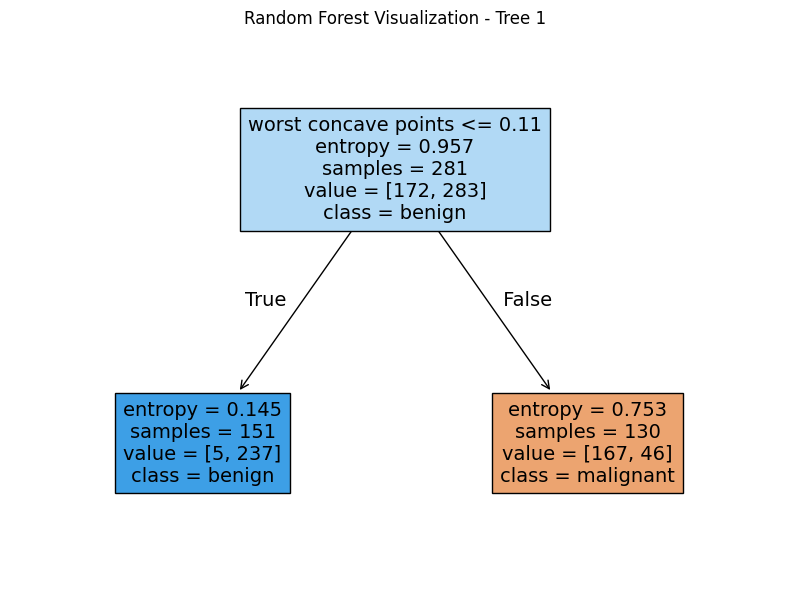

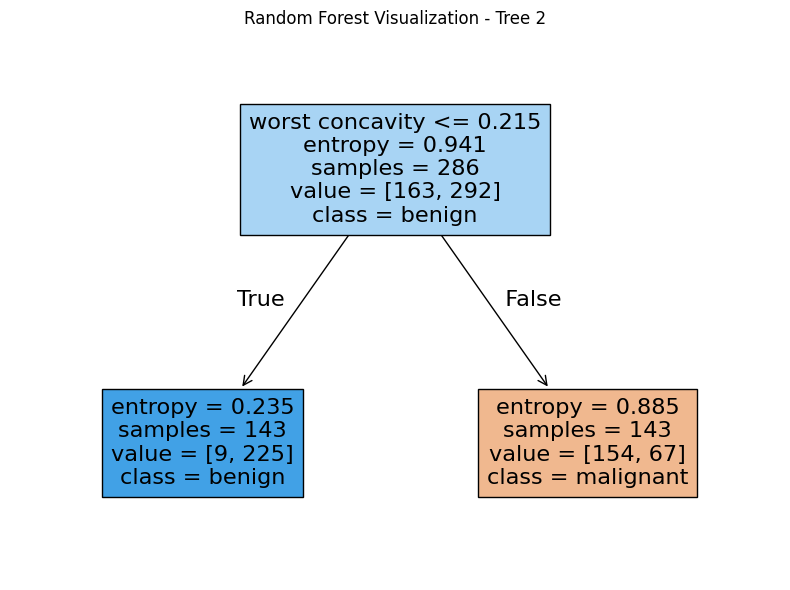

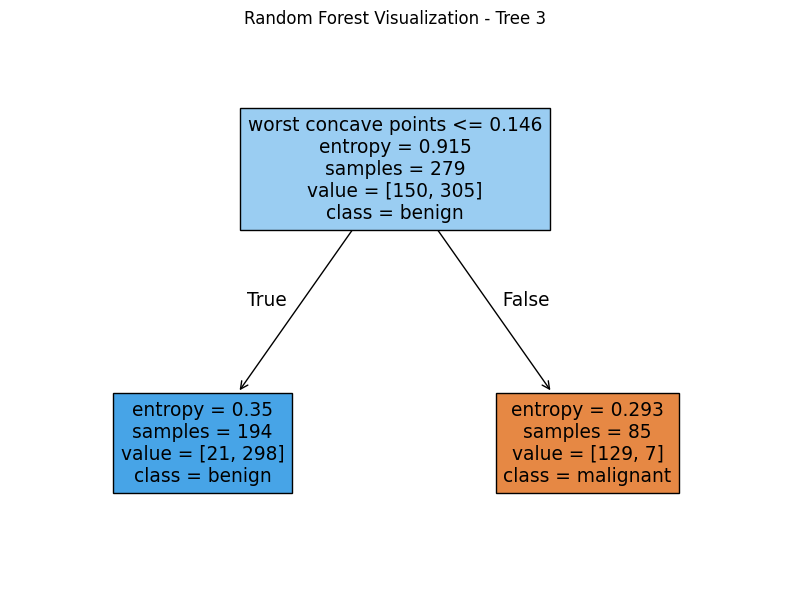

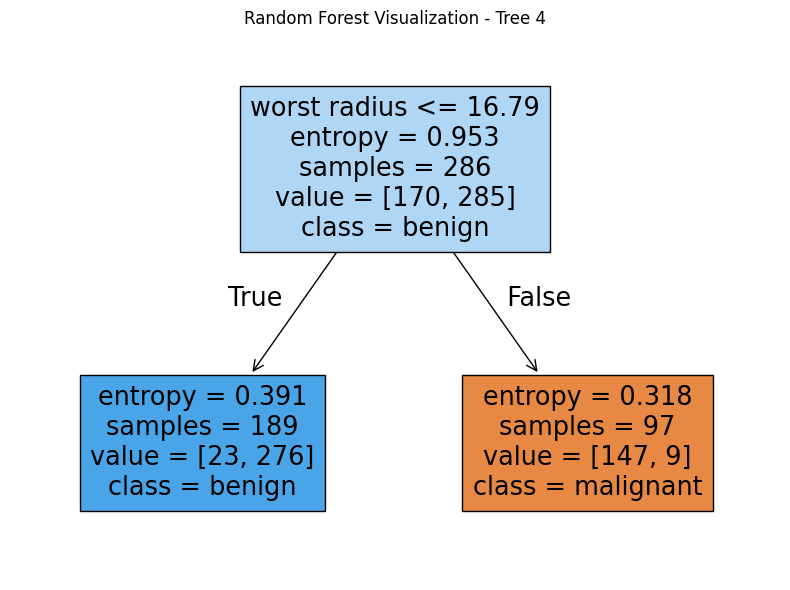

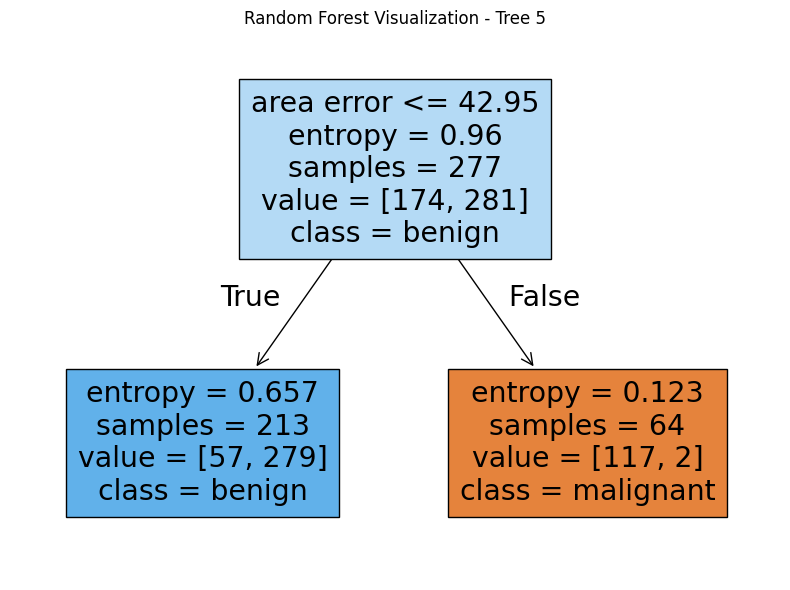

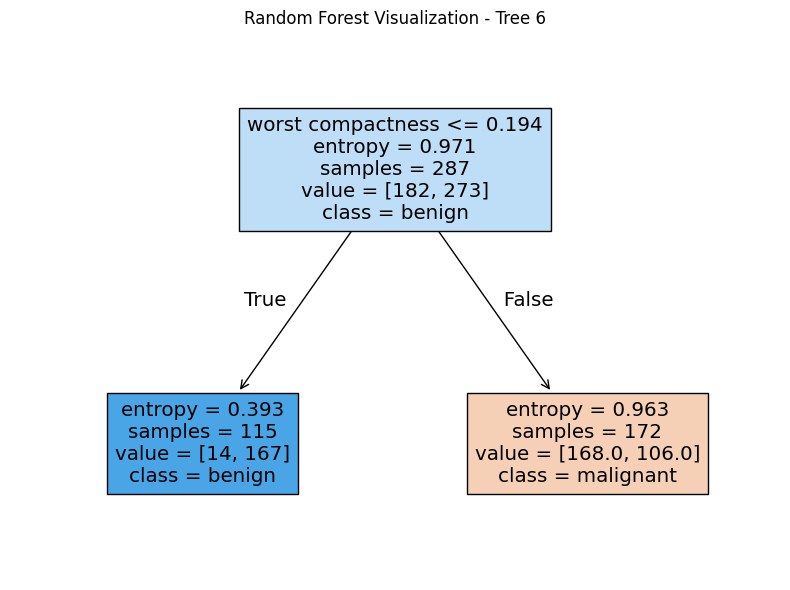

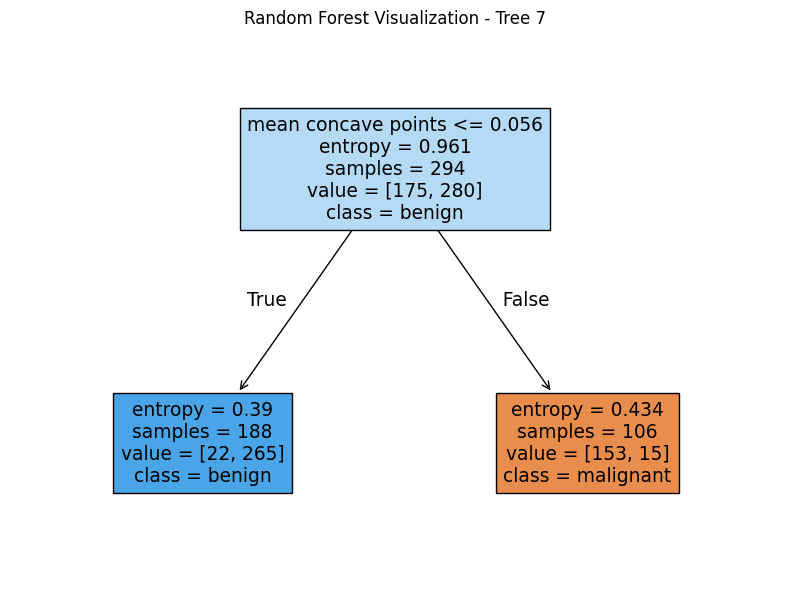

In [32]:
for idx, tree in enumerate(rf_sklearn.estimators_):
    plt.figure(figsize=(8,6))
    plot_tree(tree, filled=True, feature_names=list(breast_cancer.feature_names), class_names=list(breast_cancer.target_names))
    plt.title(f"Random Forest Visualization - Tree {idx + 1}")
    plt.tight_layout()
    plt.show()

Now choose a random sample to illustrate.

In [33]:
sample_idx = 112

pd.set_option('display.max_columns', None)
pd.DataFrame(X_test[112].reshape(1, -1), columns=breast_cancer.feature_names).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,14.22,27.85,92.55,623.9,0.08223,0.1039,0.1103,0.04408,0.1342,0.06129,0.3354,2.324,2.105,29.96,0.006307,0.02845,0.0385,0.01011,0.01185,0.003589,15.75,40.54,102.5,764.0,0.1081,0.2426,0.3064,0.08219,0.189,0.07796


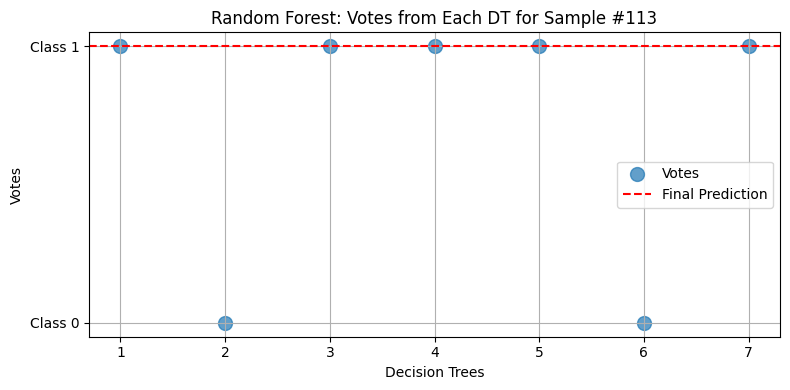

In [34]:
votes = [tree.predict(X_test[112].reshape(1, -1)) for tree in rf_sklearn.estimators_]
final_prediction = rf_sklearn.predict(X_test[sample_idx].reshape(1, -1))[0]

plt.figure(figsize=(8, 4))
plt.scatter([range(1, len(rf_sklearn.estimators_) + 1)], votes, s=100, alpha=0.7, label='Votes')
plt.axhline(y=final_prediction, color='r', linestyle='--', label='Final Prediction')
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Decision Trees')
plt.ylabel('Votes')
plt.title(f'Random Forest: Votes from Each DT for Sample #{sample_idx + 1}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In this section, again we'll use the `Breast cancer wisconsin (diagnostic)` dataset which is a binary classification dataset.

In [35]:
from xgboost import XGBClassifier, to_graphviz

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train.ravel())

xgb_predictions = xgb_model.predict(X_test)

print(f"XGB Accuracy: {accuracy_score(y_test, xgb_predictions):.3f}")
print(f"XGB F1-Score: {f1_score(y_test, xgb_predictions, average='weighted'):.3f}")

XGB Accuracy: 0.956
XGB F1-Score: 0.956


We can also use the built-in functions to plot the XGB decision rules.

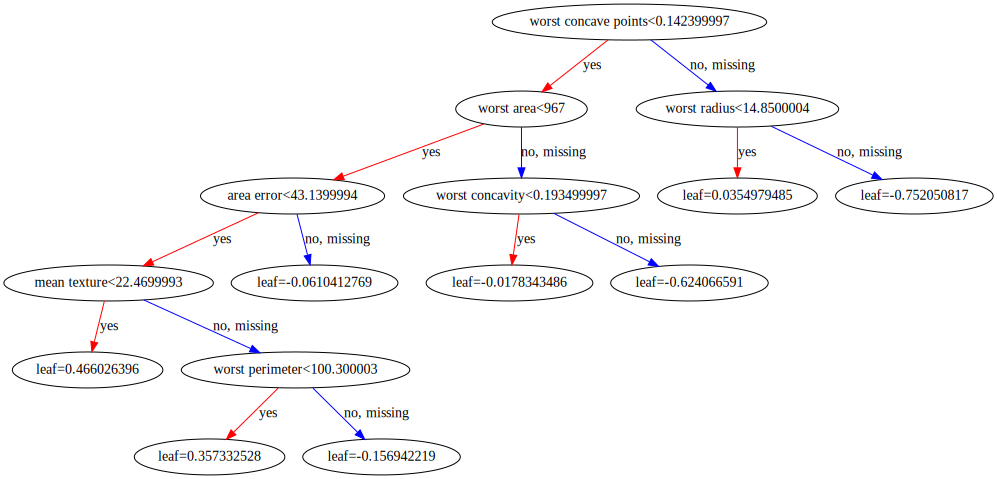

In [36]:
xgb_model.get_booster().feature_names = list(breast_cancer.feature_names)
graph = to_graphviz(xgb_model)
graph

## Comparison

First, we will utilize the `Breast Cancer Wisconsin (Diagnostic)` dataset to compare the accuracy of the two primary methods discussed earlier: `Random Forest` and `XGBoost`.

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:43:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Accuracy: 0.9561
XGBoost Accuracy: 0.9561


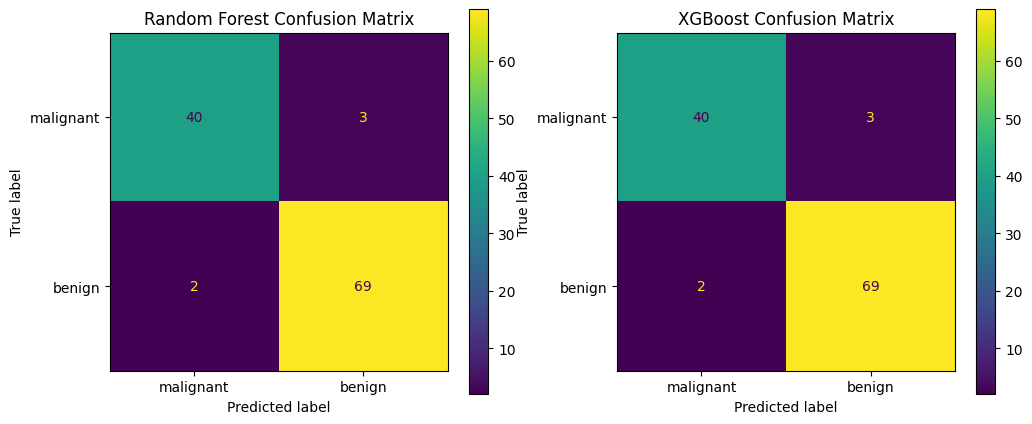


Random Forest Classification Report:
               precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        43
      benign       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

------------------------------------------------------------

XGBoost Classification Report:
               precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        43
      benign       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def test_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)

    rf_accuracy = accuracy_score(y_test, rf_predictions)
    xgb_accuracy = accuracy_score(y_test, xgb_predictions)

    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    cm_rf = confusion_matrix(y_test, rf_predictions)
    ConfusionMatrixDisplay(cm_rf, display_labels=list(breast_cancer.target_names)).plot(ax=ax[0])
    ax[0].set_title('Random Forest Confusion Matrix')

    cm_xgb = confusion_matrix(y_test, xgb_predictions)
    ConfusionMatrixDisplay(cm_xgb, display_labels=list(breast_cancer.target_names)).plot(ax=ax[1])
    ax[1].set_title('XGBoost Confusion Matrix')

    plt.show()

    print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_predictions, target_names=list(breast_cancer.target_names)))
    print("-" * 60)
    print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_predictions, target_names=list(breast_cancer.target_names)))

test_dataset(X, y)